# The JPEG compression standard
In this tutorial we will implement in Python the workflow specified by the JPEG compression standard, technically referred as [ISO/IEC 10918-1](https://www.iso.org/standard/18902.html) and Recommendation [ITU-T T.81](https://www.itu.int/rec/T-REC-T.81). Since its first publication in 1992, the standard has become the reference for image compression in mass market applications and still in 2022 has a massive legacy.

The main objective here is to provide the reader with a walkthough of the compression algorithm so that the key design aspects can be detailed and understood better. Although limited on the type of data handled, the workflow presented here will produce an output `.jpg` file which can be opened with every computer program and viewed on a display. As usual the reader is assumed to be familiar with fundamental concepts such as YCbCr colour space, discrete cosine transformation and Huffman entropy coding. Aside from the specification documents linked above, some good study material is provided by the following textbooks:
 * W. B Pennebaker and J. L. Mitchell, "JPEG: Still image data compression standard", Kluwer Academic Publishers, 638 pages, 1992.
 * David S. Taubman and Micheal W. Marcellin, "JPEG2000: Image compression fundamentals, standards and practice", Kluwer Academic Press, 773 pages, 2002.

## Introduction
The JPEG compression standard has been developed by the Joint Photographic Experts Group ([JPEG](https://jpeg.org/)) which is the Working Group 1 (WG1) of the ISO/IEC JTC1/SC29. Since its creation in 1986, JPEG has developed successfull image compression standards which enabled an effective interoperability in the digital picture era. The JPEG compression format studied in this tutorial specifies a lossy block-based DCT codec which applies uniform quantisation over DCT coefficients and then encodes them using Differential Pulse Code Modulation (DPCM) and run length encoding with Huffman codes. At high level, the encoder can be represented with the following block schema.

<img src="encoder-block-schema.png" alt="Block schema for the JPEG baseline encoder" width="1100"/>

To simplify our implementation, we will make the following assumptions on the input format and the output bitstream:
 1. Input images have bit depth equal to 8 bits per pixel
 1. If the input image's pixels are in the RGB colour space, the RGB to YCbCr colour transformation with colour primaries specified by Recommendation [ITU-R BT.709](https://www.itu.int/rec/R-REC-BT.709) is applied
 1. For input images in the YCbCr colour space, only the planar format with 4:4:4 chroma sampling ratio is supported
 1. The bitstream produced is only compliant with the *sequential DCT-based baseline* mode of operation
 1. Quantisation matrices and Huffman tables with values as per Annex K of the specification document are employed.

In the following subsections we will provide all details regarding each block in the figure along with its Python implementation. We shall mention here that the code is organised into packages, each dedicated to a specific processing stage (e.g. entropy coding). The rationale is to keep the code written in this notebook to minimal level as well as be able to provide a Python script `encoder.py` which contains the whole encoder in a more monolitic fashion so that the user can experiment more easily rather than copying and pasting the code from the Python cells below. Another simple yet efficient and compact implementation of a JPEG's encoder is provided by Stephan Brumme's [toojpeg](https://github.com/stbrumme/toojpeg) written in C++.

## Data processing prior DCT
Input images are read into memory using the `cv2` package in Python so that we can support different input formats (e.g. `bmp`, `png` and even `jpg` images, which in that case will be transcoded to a different coding rate).

As already mentioned, images in the RGB colour space are converted to the YCbCr one assuming BT.709 colour primaries. We note that the block performing such a conversion is greyed out in the block schema above. This is because the JPEG compression standard assumes that input images are always in the YCbCr colour space and how the conversion is done is out of the standard's scope, i.e. it is a pre-processing step. Indeed the JPEG compression standard was ratified in 1992 when Recommendation BT.709 was not even under definition and the JPEG committee used as reference colour primaries the ones specified in [ITU-R Recommendation BT.601](https://www.itu.int/rec/R-REC-BT.601/). However, BT.601 addressed standard definition television, whilst the images compressed with our JPEG encoder will likely be viewed on modern computer monitors which use *sRGB* colour primaries - essentially BT.709's ones - hence the choice in our tutorial.

The RGB to YCbCr conversion is performed assuming full range of the image pixels (i.e. \[0 - 255\]), this is again because we're targeting computer monitors rather than TV sets which are likely to use the so-called video range (i.e. \[16 - 235\] for luma and \[16 - 240\] for chroma). After the colour space conversion, we operate a so-called *level shift* operation whereby each image pixel value is offset by $2^{bpp-1}$ where $bpp$ denotes the bits per pixel, eight in our case. Finally, before moving to perform the following DCT and quantisation, we need to make sure that the dimensions (i.e. height and width) of our input image are a multiple of eigth. This is because the DCT, quantisation and entropy coding assume the $8\times8$ block as the atomic unit for compression. Accordingly, the image height and/or width are rounded up to the closet multiple of eight and the newly added pixels are padded from the bottom and/or rightmost samples.

The following Python code cell performs all the aforementioned processing where the colour transformation is performed using the `rgb_to_ycbcr_bt709` method from the `ct.py` package.

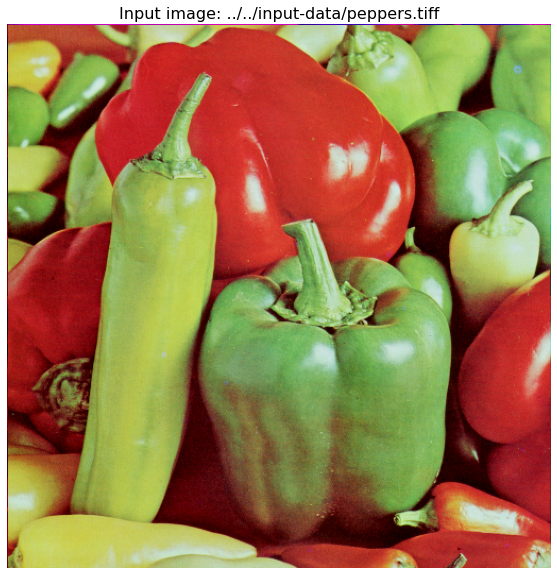

In [1]:
from pathlib import Path
import cv2
import numpy as np
from ct import rgb_to_ycbcr_bt709
import matplotlib.pyplot as plt

filename = "../../input-data/peppers.tiff"
rows, cols = 512, 512 # Reassign these in case you want to load a .yuv file

is_yuv = Path(filename).suffix == '.yuv'

# Read the image into memory and perform colour space conversion if required
if is_yuv:
    input_image = np.zeros((rows, cols, 3), dtype=np.uint8)
    with open(filename, "rb") as fh:
        input_image[:, :, 0] = np.reshape(np.frombuffer(fh.read(rows * cols), dtype=np.uint8), (rows, cols))
        input_image[:, :, 1] = np.reshape(np.frombuffer(fh.read(rows * cols), dtype=np.uint8), (rows, cols))
        input_image[:, :, 2] = np.reshape(np.frombuffer(fh.read(rows * cols), dtype=np.uint8), (rows, cols))
else:
    input_image = cv2.imread(filename, cv2.IMREAD_UNCHANGED).astype(np.uint8)
    rows, cols = input_image.shape[0], input_image.shape[1]
    red, green, blue = input_image[:, :, 2], input_image[:, :, 1], input_image[:, :, 0]
    input_image = rgb_to_ycbcr_bt709(red, green, blue)

# Level shift
input_image -= 128

# Check for image sizes to be a multiple of 8
rows8, cols8 = ((rows + 7) >> 3) << 3, ((cols + 7) >> 3) << 3
input_image8 = np.pad(input_image, ((0, rows8 - rows), (0, cols8 - cols), (0, 0)), "edge")

# Display the input image
plt.figure(figsize=(10, 10))
if is_yuv:
    # Plot just the luma component
    plt.imshow(input_image[:, :, 0], cmap="gray")
else:
    plt.imshow(np.dstack((red, green, blue)))
plt.axis("off")
plt.title(f"Input image: {filename}", fontsize=16);

## Discrete cosine transform and quantisation
### DCT
The JPEG compression standard uses a two dimensional Type-II DCT over blocks of $8\times8$ pixels. The block size 8 is a good compromise between efficiency of the DCT to exploit spatial pixel redundancy and limited computational resources (e.g. memory), particularly back in the nineties when the standard was developed. We also note that having the block size equal to a power of two would allow to implement the DCT via Fast Fourier Transform (FFT) algorithms, which, as it is well-known, are best suited for data sizes equal to powers of two. The transformation matrix $T$ can be computed as:

$$
T_{i,j} = 
\begin{cases}
\frac{1}{\sqrt{8}} & i = 0, 0\leq j\leq 8\\
\sqrt{\frac{1}{4}}\cdot\cos\left(\frac{i\cdot(2\cdot j+1)\pi}{16}\right) & 1 \leq i \leq, 0\leq j\leq 8\\
\end{cases}
$$

We note from the formulation above that the DCT requires floating point arithmetic. On hardware where the arithmetic circuitry has a limited number of bits, the DCT is usually implemented with fixed point arithmetic, i.e. scaling the values of $T$ by a given number of bits, representing the transform's precision. A little thought should convince the reader that if the encoder and decoder use a different precision to implement the forward and inverse DCT, a mismatch in the decoded image might occur, especially at high coding rates where more coefficients are not zero out by quantisation. The drift introduced might be even more problematic when temporal prediction (i.e. inter prediction) in videos is used. Indeed, such a problem was well-known back in MPEG-2's days and motivated to issue some guidelines to specify the bit precision of the DCT were standardised in [ISO/IEC 23002-1](https://www.iso.org/standard/42030.html). Additionally, the drift is probably one of the most compelling reasons that led to specify an integer approximation of the DCT in the MPEG-2's successors such as the H.264/AVC, H.265/HEVC and H.266/VVC.

The 2D DCT over the input $8\times8$ block $x$ can then be expressed via matrix multiplication as follows:

$$
X = T\cdot x\cdot T^{t},
$$

where $^t$ denotes the transposition operation and $X$ is the resulting block of transform coefficients. Such a matrix multiplication will be used to implement the 2D $8\times8$ DCT for our JPEG encoder.


### Quantisation
Quantisation in the JPEG compression format is scalar and uniform. The standard supports the use of quantisation matrices (tables in the standard) for the luma and chroma components. The user can define their own and transmit to the decoder via the Define Quantisation Table (DQT) segment marker (with identification code equal to 0xDB). In this tutorial we will instead use the ones suggested in Annex K of [ITU-T T.81](https://www.itu.int/rec/T-REC-T.81) which are the result of the seminal work by [Peterson et al.](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/1453/0000/Quantization-of-color-image-components-in-the-DCT-domain/10.1117/12.44357.short?SSO=1) from 1991. The values for both the luma and chroma planes are reported in the following tables, printed out from the respective numpy arrays defined in the Python package `quantiser`.

In [2]:
from quantiser import luma_quantisation_matrix, chroma_quantisation_matrix
from tabulate import tabulate

headers = [""] * 16
headers[0] = "Luma"
headers[8] = "Chroma"
qm_all = np.zeros((8, 16), np.int32)
qm_all[:, :8] = luma_quantisation_matrix
qm_all[:, 8:] = chroma_quantisation_matrix

qm_table = tabulate(qm_all, headers, tablefmt="fancy_grid")

print(qm_table)

╒════════╤════╤════╤════╤═════╤═════╤═════╤═════╤══════════╤════╤════╤════╤════╤════╤════╤════╕
│   Luma │    │    │    │     │     │     │     │   Chroma │    │    │    │    │    │    │    │
╞════════╪════╪════╪════╪═════╪═════╪═════╪═════╪══════════╪════╪════╪════╪════╪════╪════╪════╡
│     16 │ 11 │ 10 │ 16 │  24 │  40 │  51 │  61 │       17 │ 18 │ 24 │ 47 │ 99 │ 99 │ 99 │ 99 │
├────────┼────┼────┼────┼─────┼─────┼─────┼─────┼──────────┼────┼────┼────┼────┼────┼────┼────┤
│     12 │ 12 │ 14 │ 19 │  26 │  58 │  60 │  55 │       18 │ 21 │ 26 │ 66 │ 99 │ 99 │ 99 │ 99 │
├────────┼────┼────┼────┼─────┼─────┼─────┼─────┼──────────┼────┼────┼────┼────┼────┼────┼────┤
│     14 │ 13 │ 16 │ 24 │  40 │  57 │  69 │  56 │       24 │ 26 │ 56 │ 99 │ 99 │ 99 │ 99 │ 99 │
├────────┼────┼────┼────┼─────┼─────┼─────┼─────┼──────────┼────┼────┼────┼────┼────┼────┼────┤
│     14 │ 17 │ 22 │ 29 │  51 │  87 │  80 │  62 │       47 │ 66 │ 99 │ 99 │ 99 │ 99 │ 99 │ 99 │
├────────┼────┼────┼────┼─────┼─────┼───

As we can see these matrices follow the well-known masking phenomeon of the Human Visual System (HVS) associated with the sensitivity to quantisation introduced at different spatial frequencies. In particular the human eye shows a bandpass behaviour and several indepedent studies confirmed this. The findings from these studies, combined with additional models of the contrast sensitivity function of the HVS, have then been used to derive different and more content adaptive values for the quantisation matrices. The interest reader is referred to the remarkable papers from [A. B. Watson](https://human-factors.arc.nasa.gov/organization/personnel_view.php?personnel_id=62) when still at the NASA research centre. Additionally, Googling for contrast sensitivity function and/or Just Noticeable Different (JND) in images and videos should provide enough references to grasp the fundamentals of this research topic.

Going back to our implementation of a JPEG encoder, we will use the suggested quantisation matrices coupled with a quality fact $QF$ in the range \[1, 100\] to modulate the coding rate. In particular, the matrix's values will be multiplied by a scaling factor $S$ which is derived from $QF$ as established by the Indipendent JPEG Group ([IJG](https://www.ijg.org/)):

$$
S = 
\begin{cases}
\frac{5000}{QF} & QF \leq 50 \\
200 - 2\cdot QF & otherwise
\end{cases}.
$$

Then, for the DCT coefficient at spatial frequency $(i,j)$ and component (i.e. luma or chroma) $k$, its quantisation divisor $Q[i,j,k]$ is derived from $S$ as:

$$
Q[i,j,k] = \left\lfloor\frac{50 + S\cdot \bar{Q}[i,j,k]}{100}\right\rfloor,
$$

where, $\bar{Q}$ denotes the value as suggested in Annex K of the JPEG compression standard standard specification.

Actual quantisation is then implemented as integer division of each DCT coefficient, $X[i,j,k]$ in an $8\times8$ block by the corresponding entry in the quantisation matrix. This produces the so-called quantised levels $l[i,j,k]$:

$$
l[i,j,k] = \left\lfloor\frac{X[i,j,k] + r}{Q[i,j,k]}\right\rfloor,
$$

being $r$ a rounding factor which modulates the extent of the quantiser's dead zone (i.e. the quantisation bin around the zero value). In this tutorial, we set $r=0.5$.

### Putting all together
DCT and quantisation are now implemented in the following Python code cell. The method `compute_dct_matrix` from the `dct` package is used to compute the DCT kernel matrix for the desired block size (8 in our case). The method `compute_quantisation_matrices` from the `quantiser` pakage is instead use to compute the actual values of the quantisation matrices for luma and chroma, adjusted by the quality factor which is set to 90 in this tutorial. Actual DCT calculation via matrix multiplication is carried out by the method `compute_dct` from the `dct` package whilst quantisation is a simple division implemented through the `divide` method from `numpy`.

Given the $8\times8$ block granularity for DCT and quantisation, we will implement a for loop which retrieves each block by a *slicing* operation over a `numpy` array. We note that we don't need to worry about whether a given image will have its height and/or width which is not a multiple of eight, given that we adjusted both sizes earlier. Each plane of the resulting block is then transformed with the `compute_dct` method. Conversely, quantisation considers all colour planes together. Accordinly, we would need to stack together the matrices for luma and chroma using the `dstack` method from `numpy`. The resulting levels $l[i.j,k]$ are stored in a 3D `numpy` array denoted as `image_dct_q`.

In [3]:
from quantiser import compute_quantisation_matrices
from dct import compute_dct, compute_dct_matrix

# Derive the quantisation matrices from the quality factor QF
QF = 90
qy, qc = compute_quantisation_matrices(QF)
qm = np.dstack((qy, qc, qc)).astype(np.float64)

# Derive the DCT kernel matrix for an 8x8 block
T = compute_dct_matrix(8)

# Loop over all 8x8 blocks, compute the 2D DCT and quantise the transform coefficients
image_dct_q = np.zeros(input_image8.shape, np.int32)
block_t = np.zeros((8, 8, 3), np.float64)
for r in range(0, rows8, 8):
    row_slice = slice(r, r + 8)
    for c in range(0, cols8, 8):
        col_slice = slice(c, c + 8)
        block = input_image8[row_slice, col_slice].astype(np.float64)
        block_t[:, :, 0] = compute_dct(block[:, :, 0], T)
        block_t[:, :, 1] = compute_dct(block[:, :, 1], T)
        block_t[:, :, 2] = compute_dct(block[:, :, 2], T)
        image_dct_q[row_slice, col_slice] = np.divide(block_t + 0.5, qm).astype(np.int32)

## Entropy coding
The coding of quantised levels in the JPEG compression standard is based on the following five aspects:
 1. Category codes
 1. Differential Pulse Code Modulation (DPCM) of DC coefficients
 1. Zigzag scanning of AC coefficients
 1. Run length encoding with alphabet extension
 1. Huffman coding

It is worthwhile to clarify the rationale behind each of these aspects before proceeding with the actual Python code implementing entropy coding. This is done in the next subsections.

### Category codes
The DCT applied over $8\times8$ blocks scales up their values by the so-called transform gain which, for an orthonormal transform, is equal to the block size (8). Given the level shift operation applied at the beginning of the encoding chain, we would have $2^{bpp + 3 + 1}$ different values out of the quantiser when the quantisation step is equal to 1. So a sequential DCT baseline bistream up to $2^{14}$ values are possible. Designing the Huffman tables for such a large set of values is not efficient: the amount of overhead to transmit to the decoder is significant and so is the memory required to store the tables when entropy encoding is performed. The JPEG compression standard addresses this problem by introducing the concept of *category code* which maps each level $l[i,j,k]$ to a pair $(c,u)$ where $c$ denotes the *size category*, that is the smallest number of bits to represent $|l[i,j,k]|$:

$$
c = \left\lceil\log_2(|l[i,j,k]| + 1)\rceil\right.
$$

Quantity $u$ instead denotes the remainder of $|l[i,j,k]|$ with respect to $2^c$. DCT quantised coefficients are distributed according to a Laplacian probability mass function (see [this paper](https://ieeexplore.ieee.org/document/869177) for more details) and considering the *size category* of each coefficient we are still "sitting" on the same distribution which is not uniform, hence variable length coding will bring advantages to whole compression efficiency. Accordingly, the JPEG compression standard applies Huffman encoding to the size category values. Remainder values $u$ are instead written as binary quantities with $c$ bits. This is because within each bin of length $2^c$ the probability mass function can be considered approximately uniform, hence the remainder would not benefit by any entropy coding (this consideration is analogous to the one that led the design of Golomb codes as we have discussed already in this [tutorial](../../entropy-coding/golomb-coding/golomb-coding-tutorial.ipynb)). We note that when $|l[i,j,k]| \equiv 0$ then the size category is zero and there is no need to transmit $u$. Conversely when $|l[i,j,k]| \neq 0$, $u$ should also convey the sign of $l[i,j,k]$: the convention adopted here is that when $|l[i,j,k]| > 0$ then $u$ starts with a 1 followed by the $c-1$ least significant bits of $|l[i,j,k]|$. Conversely, when $|l[i,j,k]| < 0$ then $u$ starts with a 0 followed by the 1's complement of the $c-1$ least significant bits of $|l[i,j,k]|$. We can express the calculation of $u$ with the following formula:

$$
u = \begin{cases}
2^c - 1 - |l[i,j,k]| & l[i,j,k] < 0 \\
l[i,j,k] & otherwise
\end{cases}.
$$

Given that the we encoder the sign in remainder part of the category codes, we would have that $0 \leq c \leq bpp + 3$, that is no more than eleven categories in our case or up to fifteen when $bpp=12$ (extended JPEG compression format).

### Differential Pulse Code Modulation (DCPM) of DC coefficients
DPCM is a coding paradigm/framework whereby residuals, with respect to a predictor, are transmitted rather than the original data. The predictor can exploit spatial or temporal redundancy, leading to the so-called intra or inter coding, two very well-known techniques in the image and video coding community which are at the foundation of the codec families specified by the H.26x and MPEG-x standards. The JPEG compression standard applies DPCM over the DC levels. These values represent the average pixel intensity of each $8\times8$ block. Given that images can contain large regions with similar pixel intensities, transmitting the residuals across DC values will likely boost the coding efficiency. The predictor used for each coding block is given by the DC value of the previous block in raster scan order: this is represented in our block schema above by the *delay block* labelled as $z^{-1}$, a symbology borrowed from digital signal processing. The first coding block will use a zero value predictor. The reader familiar with the DPCM framework might have a bell ringing in their mind about the possibility to have drift between the encoder and decoder should the predictor not be carefully chosen. This is true when quantisation happens after the residuals has been computed but it is not the case for the JPEG compression standard. Accordingly as long as the initial value of the predictor is specified both for the receiver and trasmitter (zero in our case) no drift will occur. Finally we note that DPCM over the DC values will not be needed or would even be detrimental to coding efficiency if spatial or temporal prediction is employed as in a codec ala MPEG. In this case a linear predictor - spatial or motion compensated one - is used, which from the Kolmogorov-Wiener's theory of prediction, we know it can efficiently estimate first order statistics such as the average pixel intensity. Consequentely each block will have zero value mean (we are encoding a full residuals block) hence its associated DC value will be practically zero and, more importantly, uncorrelated with any adjacent block, which is the reason why any DPCM applied afterwards will likely worsen the coding efficiency.

### Zigzag scanning of AC coefficients
The remaining 63 AC coefficients are re-arranged in a 1D array obtained by scanning them according to a zigzag pattern illustrated in the following figure.

<img src="zigzag-scan.png" alt="Zigzag scan of DCT quantised coefficients" width="400"/>

Such a pattern has a twofold purpose: on one hand it sorts the DCT quantised coefficients in a descending order with respect to their magnitude and variance. On the other hand, the pattern increases the chances of creating long runs of zero values which can efficiently be exploited in the following run length encoding stage. We note that alternative scanning patterns may have also be considered, such as the diagonal one specified in the H.265/HEVC standard.

### Run length encoding with alphabet extension
Run length encoding is a well-known entropy coding technique whereby sequences of same value $v$ are grouped together in pairs $(r,v)$ where $r$ denotes the length of the sequence, commonly called the run. The JPEG compression standard considers only runs of zeros: this is because the use of DCT will pack the energy of each $8\times8$ block into the low frequency coefficients, leaving all the remaining ones to be set to zero after quantisation. Rather than encoding the run lengths and values separately, thus needing to use two different Huffman tables, the JPEG comrpession standard packs each $(r,v)$ pair into a 8 bit codeword whereby the top 4 bits represent the size category for $v$ and the bottom 4 bits represent the length of the run of zeros. The figure below depicts the packing.

<img src="run-length-packing.png" alt="Packing of a run length value pair" width="600"/>

Over the packed run length pairs, Huffman coding is applied. As we said above, eleven different category sizes are needed and sixteen different runs of zero values are possible. Accordingly, we would need $11\times16 = 176$ codes. Out of these 176, 15 are associated with invalid packed values, namely $(l, 0)$. Only one of these *invalid* values is retained, the pair $(0,0)$ which is used are special code to signal the so-called End Of Block (EOB), a position in the zigzag scan order beyond which no quantised level different from zero is present in an $8\times8$ block. An example of EOB is illustrated in the following figure.

<img src="eob-example.png" alt="EOB example" width="400"/>

Accordingly, we would have $176 - 15 + 1 = 162$ Huffman codes. The pair $(15, 0)$ is used when runs with length larger than 16 are present in the block and need to be split into multiple codewords given that the maximum allowed length in the packing scheme of run length pairs is sixteen. Such a packing provides an *extension* to the initial alphabets of category sizes ($[0,11]$) and run lengths ($[0,16]$) which are now transformed into the alphabet of integer symbols ($[0,162]$). We shall also recall that for each run length value pair, the remainder $u$ of each category code needs to be transmitted as well. This is simply written after the codeword associated with the pair.

### Huffman coding
The cateogry sizes associated with residuals DC levels and packed run length value pairs for AC levels are encoded using Huffman codes, derived with the well-known related procedure. To simplify the entropy encoding procedure, we can arrange these codes into a lookup table whereby for each symbol the corresponding entry indicates the Huffman code. DC and packed run length value pairs shown different statistics and so do luma and chroma channels. Accordingly, the JPEG compression standard allows to send different Huffman codes for each one of these different type of data, hence up to four different tables of codes may be transmitted by the encoder. Rather than transmitting the full loopup table, the standard specifies an alternative representation whereby two 1D arrays are used: `bits` and `values` (see Section C of [ITU-T T.81](https://www.itu.int/rec/T-REC-T.81) for more details). For the `bits` array, its $i$-th entry indicates how many symbols are encoded with $i+1$ bits. The following figure shows an example of one `bits` array.

<img src="bits-array.png" alt="Example of bits array values" width="500"/>

The `values` array expands depending on the `bits` one: for each entry $i$, `bits[i]` entries of the `values` arrays are assigned to a codeword with $i+1$ bit length as indicated in the following figure.

<img src="bits-values-mapping.png" alt="Example of mapping between bits and values arrays" width="600"/>

We note that the relationship between the `bits` and `values` arrays implies that the sum of all entries in `bits` equals to the number of entries in `values`. In this tutorial we will be using the default Huffman tables defined in [Annex K.3](https://www.itu.int/rec/T-REC-T.81) of the JPEG compression standard. These tables have been derived over a wide range of statistics associated with natural content and variable rates of compression rates. Given that the standard transmits this information in the bistream, the encoder can work out better tables to improve the compression efficiency at the cost of increased complexity given that the whole image needs to be compressed first so that the Huffman coding procedure can be applied.

Finally, we should conclude this discussion on Huffman table by noting that JPEG compression standard mandates that the `bits` array shall have at most sixteen entries. This is to limit the length of Huffman codewords to 16 bits so that speculative decoding techniques can be applied whereby the decoder reads chunks of 16 bits from the bistream and looks up into a table with $2^{16}$ entries. Each entry in this table indicates which Huffman code corresponds to the prefix of the current chunk as well as how many bits (say $L$) such code is long. The decode then can discard $L$ bits from the current chunk and adds as many bits from the bitstream to reach again 16 bits. The look up operation just described can continue until the whole image is decoded. Such a technique provides a faster decoding time than reading each bit from the bitstream and look up in the corresponding Huffman table to understand whether a match with a valid codeword is found. The price to pay for these speedup is an inevitable higher memory consumption. [Annex K.2](https://www.itu.int/rec/T-REC-T.81) of the JPEG compression standard describes a procedure to limit the length of Huffman codes to 16 bits.

### Putting all together
At last we're in a position to implement the entropy coding processing specified by the JPEG compression standard. The Python package `entropy` contains all methods and data needed as follows:
 * `chroma_ac_bits`, `chroma_ac_values`, `chroma_dc_bits`, `chroma_dc_values`, `luma_ac_bits`, `luma_ac_values`, `luma_dc_bits`, `luma_dc_values`: These are `numpy` arrays which contain the bits and values associated with the Huffman tables for different DCT coefficients and colour planes.
 * `expand_huffman_table`: A Python method which takes the `bits` and `values` arrays and returns the corresponding Huffman table which is then used to perform entropy coding of category sizes and packed run length value pairs.
 * `get_zigzag_scan`: A Python method which returns the zigzag scan index array for a given block size passed as input parameter.
 * `encode_block`: A Python method which, for each $8\times8$ block of quantised levels performs the processing described in this section for entropy coding, that is: DC residuals coding and run length value coding using a Huffman table. The function doesn't write the Huffman codewords directly to the bitstream but rather returns a Python dictionary with the following two keys: `DC` and `AC`, correspondig to the two types of quantised coefficients encoded. Each dictionary key points to a Python list of pairs where the first element of the pair indicates the codeword value and the second tells the number of bits used to encode it. We decided to return the output distinguished by DC and AC coefficients to allow the reader to perform additional statistics analysis on the codewords.

The following Python cell puts in place a workflow similar to the one already implemented for DCT and quantisation whereby all $8\times8$ blocks are processed in raster scan and Y, Cb and Cr colour plane order. We note that the call of the `encode_block` method could have been placed in the for loops associated with DCT and quantisation. Having an additional set of nested for loops would inevitably slow down the processing, most notably for high resolution images. However, in order to keep the explanation given in this notebook waterfall style, we prefer to add the loops associated with entropy coding.

In [4]:
from entropy import (chroma_ac_bits, chroma_ac_values, chroma_dc_bits,
                     chroma_dc_values, encode_block, expand_huffman_table,
                     get_zigzag_scan, luma_ac_bits, luma_ac_values,
                     luma_dc_bits, luma_dc_values)

_, zigzag_scan = get_zigzag_scan(8)

# Luma Huffman table generation
luma_dc_table = expand_huffman_table(luma_dc_bits, luma_dc_values)
luma_ac_table = expand_huffman_table(luma_ac_bits, luma_ac_values)

# Chroma Huffman table generation
chroma_dc_table = expand_huffman_table(chroma_dc_bits, chroma_dc_values)
chroma_ac_table = expand_huffman_table(chroma_ac_bits, chroma_ac_values)

total_blocks = rows8 * cols8 // 64
dcp_y, dcp_cb, dcp_cr = 0, 0, 0
block_idx = 0
y_cw, cb_cw, cr_cw = [None] * total_blocks, [None] * total_blocks, [None] * total_blocks
zigzag_idx = zigzag_scan.flatten()
for r in range(0, rows8, 8):
    row_slice = slice(r, r + 8)
    for c in range(0, cols8, 8):
        col_slice = slice(c, c + 8)
        block_y = image_dct_q[row_slice, col_slice, 0].flatten()
        block_cb = image_dct_q[row_slice, col_slice, 1].flatten()
        block_cr = image_dct_q[row_slice, col_slice, 2].flatten()

        y_cw[block_idx] = encode_block(block_y[zigzag_idx], dcp_y, luma_dc_table, luma_ac_table)
        cb_cw[block_idx] = encode_block(block_cb[zigzag_idx], dcp_cb, chroma_dc_table, chroma_ac_table)
        cr_cw[block_idx] = encode_block(block_cr[zigzag_idx], dcp_cr, chroma_dc_table, chroma_ac_table)

        dcp_y, dcp_cb, dcp_cr = block_y[0], block_cb[0], block_cr[0]
        block_idx += 1

## Packetisation
In this stage we write some high level syntax metadata. Despite these high level syntax data are not necessary to understand the core coding tools specified by the JPEG compression standard, they are required to make the bitstream decodable. The reader would also remember that we said at the beginning of this tutorial that the output of our encoder is going to be a file which can simply be opened by any modern operative system and then displayed on computer monitor.

The JPEG compression standard writes the metadata by means of *marker segments*, which are segments of bytes in the bitstream which start with the following combination of two bytes: `0xFFK` where `K` denotes a bytes whose value is in the range \[1, 254\] and each value then specifies in the standard how the following bytes in the segment should be read and interpreted (see [Annex B](https://www.itu.int/rec/T-REC-T.81) for more details). The following marker segments will be used:
 1. JFIF (JPEG File Interchange Format): This segment provides information which is specified by [ITU-T Recommendation T.871](https://www.itu.int/rec/T-REC-T.871-201105-I/en) and is needed to specify parameters such as pixel density units, etc.
 1. Comment: This is not strictly required but it has been used to put our signature in the bitstream generated.
 1. Quantisation tables: This marker provides the decoder with the multiplier values to be used when the entropy decoded DCT levels are reconstructed.
 1. Start of frame: This marker conveyes information such as image height and width.
 1. Huffman table: This marker provides the decoder with `bits` and `values` arrays which can then be expanded to have a Huffman table to perform entropy decoding.
 1. Start of scan: This marker provides information about the scan, i.e. the sequence of coding blocks composing the compressed image.

Each marker segment is written using fixed length encoding and usually on a byte basis. The Python package `syntax.py` provides all methods required to write the above markers. After these initial metadata are written, the payload associated with the entropy coded DCT quantised coefficients can be inserted in the bitstream. To write both the segment markers as well as the Variable Length Coding (VLC) payload, a helper Python class denoted as `BitWriter` from the `bit_io.py` package is used. A `BitWriter` object is able to write integer values with a given number of bits, which is exactly what we need to write the Huffman codewords calculated for the DC and AC levels by the `encode_block` method. The read will notice that when the bit accumulator variable of `BitWriter` needs to be dumped to the output bitstream file, the class checks whether the byte just dumped was equal to `0xFF`. If this is the case, the class adds a zero value byte. This is needed to avoid any high level syntax parser which reads the bitstream to scan segment markers only to be misled and believe that in the middle of the VLC payload a marker has been inserted by the encoder. The two byte sequence `0xFF00` does not correspond to any legal segment marker in the JPEG compression standard, hence the parser will ignore it and continue.

The following Python code cell performs the writing of the marker segments above as well as the VLC payload by looping through all codewords for the DC and AC levels associated with the Y, Cb and Cr colour planes. The `BitWriter` is also flushed at the end to dump any partially written bits and then an End of Image segment marker is also written so that the decoder knows when to stop the parsing.

In [8]:
from bit_io import BitWriter

from syntax import (write_comment, write_huffman_table, write_jfif_header,
                    write_quantisation_tables, write_segment_marker,
                    write_start_of_frame, write_start_of_scan)

bitstream_name = "bitstream.jpg"

bw = BitWriter(bitstream_name)

write_jfif_header(bw)
write_comment(bw, "VCT JPEG encoder in Python")
write_quantisation_tables(bw, qy.flatten()[zigzag_idx], qc.flatten()[zigzag_idx])
write_start_of_frame(bw, rows, cols)
write_huffman_table(bw, luma_dc_bits, luma_dc_values, luma_ac_bits, luma_ac_values,
                    chroma_dc_bits, chroma_dc_values, chroma_ac_bits, chroma_ac_values)
write_start_of_scan(bw)

# Write the VLC payload
for payload_y, payload_cb, payload_cr in zip(y_cw, cb_cw, cr_cw):
    # Y
    for code in payload_y["DC"]:
        bw.submit_bits(code[0], code[1])
    for code in payload_y["AC"]:
        bw.submit_bits(code[0], code[1])

    # Cb
    for code in payload_cb["DC"]:
        bw.submit_bits(code[0], code[1])
    for code in payload_cb["AC"]:
        bw.submit_bits(code[0], code[1])

    # Cr
    for code in payload_cr["DC"]:
        bw.submit_bits(code[0], code[1])
    for code in payload_cr["AC"]:
        bw.submit_bits(code[0], code[1])

bw.flush()

# Write the end of image segment marker
write_segment_marker(bw, 0xD9, 0)

bw.terminate()

## Testing the encoder
The workflow implemented so far allows to encode an input image and produce a `.jpg` file which can then be visualised over a computer display. The quality factor selected above has value equal to 90 which, over the input image `peppers.tiff`,  produces a bitstream with size 80.361 bytes, corresponding to a coding rate of 2.45 bpp. We are now interested in testing out workflow for different values of the quality factor to appreciate its coding efficiency. We will use as image quality indicator the Peak Signal-to-Noise-Ratio (PSNR) computed in the YCbCr colour space and will plot the rate-distortion curves considering the PSNR over the luma component. To do this assessment exercise, we will use the `jpeg_encoding` method provided by the `encoder.py` package which replicates in a more self contained form the workflow implemented so far in this tutorial.

We are also interested in understanding how our toy JPEG encoder compares with respect to a practical implementation such as the one that ships with the `cv2` Python package (essentially the [OpenCV](https://opencv.org/) library). Accordingly, the following Python cell will compress the input image `peppers.tiff` with both ours and the OpenCV's encoder. To collect the rate-distortion point, the quality factor will be varied in the range \[0, 100\] with steps of 20 units. Given that it is likely that the OpenCV encoder will convert the input image in the YCbCr colour space with BT601 primaries, we will also follow the same convention, given that, as we stated above, the JPEG standard is agnostic to the colour primaries used, as long as the input image is represented in the YCbCr colour space.

In [6]:
from ct import rgb_to_ycbcr_bt601
from encoder import jpeg_encoding
import os

image_cv2 = np.dstack((blue, green, red))
input_image_601 = rgb_to_ycbcr_bt601(red, green, blue)
quality = [0, 20, 40, 60, 80, 100]
psnr = np.zeros((len(quality), 3))
psnr_cv2 = np.zeros((len(quality), 3))
coding_rate = np.zeros((len(quality)))
coding_rate_cv2 = np.zeros((len(quality)))
bitstream_cv2 = "bitstream_cv2.jpg"

for idx, q in enumerate(quality):
    q = max(q, 1)

    # Python JPEG encoder
    total_bytes, _ = jpeg_encoding(input_image_601, bitstream_name, q)
    coding_rate[idx] = total_bytes * 8 / rows / cols
    image_rec = cv2.imread(bitstream_name, cv2.IMREAD_UNCHANGED).astype(np.uint8)
    image_rec_ycbcr = rgb_to_ycbcr_bt601(image_rec[:, :, 2], image_rec[:, :, 1], image_rec[:, :, 0])
    for comp in range(3):
        mse = np.mean(np.square(input_image_601[:, :, comp] - image_rec_ycbcr[:, :, comp]))
        psnr[idx, comp] = 10 * np.log10(255 ** 2 / mse)

    # cv2 JPEG encoder
    cv2.imwrite(bitstream_cv2, image_cv2, [int(cv2.IMWRITE_JPEG_QUALITY), q])
    total_bytes_cv2 = os.path.getsize(bitstream_cv2)
    coding_rate_cv2[idx] = total_bytes_cv2 * 8 / rows / cols
    image_rec_cv2 = cv2.imread(bitstream_cv2, cv2.IMREAD_UNCHANGED).astype(np.uint8)
    image_rec_ycbcr_cv2 = rgb_to_ycbcr_bt601(image_rec_cv2[:, :, 2], image_rec_cv2[:, :, 1], image_rec_cv2[:, :, 0])
    for comp in range(3):
        mse = np.mean(np.square(input_image_601[:, :, comp] - image_rec_ycbcr_cv2[:, :, comp]))
        psnr_cv2[idx, comp] = 10 * np.log10(255 ** 2 / mse)

    print(f"Quality factor: {q:2d}")
    print(f"\tPython JPEG - bpp: {coding_rate[idx]:.2f}, PSNR-Y: {psnr[idx, 0]:.2f} dB, PSNR-Cb: {psnr[idx, 1]:.2f} dB, PSNR-Cr: {psnr[idx, 2]:.2f} dB")
    print(f"\tOpenCV JPEG - bpp: {coding_rate_cv2[idx]:.2f}, PSNR-Y: {psnr_cv2[idx, 0]:.2f} dB, PSNR-Cb: {psnr_cv2[idx, 1]:.2f} dB, PSNR-Cr: {psnr_cv2[idx, 2]:.2f} dB")

# Remove the byproduct created
os.remove(bitstream_name)
os.remove(bitstream_cv2)

Quality factor:  1
	Python JPEG - bpp: 0.26, PSNR-Y: 20.59 dB, PSNR-Cb: 21.66 dB, PSNR-Cr: 23.34 dB
	OpenCV JPEG - bpp: 0.18, PSNR-Y: 24.39 dB, PSNR-Cb: 27.08 dB, PSNR-Cr: 25.48 dB
Quality factor: 20
	Python JPEG - bpp: 0.47, PSNR-Y: 30.35 dB, PSNR-Cb: 32.14 dB, PSNR-Cr: 31.64 dB
	OpenCV JPEG - bpp: 0.45, PSNR-Y: 32.47 dB, PSNR-Cb: 32.10 dB, PSNR-Cr: 31.41 dB
Quality factor: 40
	Python JPEG - bpp: 0.69, PSNR-Y: 32.64 dB, PSNR-Cb: 34.12 dB, PSNR-Cr: 33.78 dB
	OpenCV JPEG - bpp: 0.69, PSNR-Y: 34.23 dB, PSNR-Cb: 33.04 dB, PSNR-Cr: 32.58 dB
Quality factor: 60
	Python JPEG - bpp: 0.91, PSNR-Y: 33.82 dB, PSNR-Cb: 35.60 dB, PSNR-Cr: 34.79 dB
	OpenCV JPEG - bpp: 0.93, PSNR-Y: 35.30 dB, PSNR-Cb: 33.87 dB, PSNR-Cr: 33.23 dB
Quality factor: 80
	Python JPEG - bpp: 1.46, PSNR-Y: 35.49 dB, PSNR-Cb: 37.01 dB, PSNR-Cr: 36.22 dB
	OpenCV JPEG - bpp: 1.47, PSNR-Y: 36.79 dB, PSNR-Cb: 34.37 dB, PSNR-Cr: 34.18 dB
Quality factor: 100
	Python JPEG - bpp: 14.22, PSNR-Y: 50.31 dB, PSNR-Cb: 50.55 dB, PSNR-Cr: 50

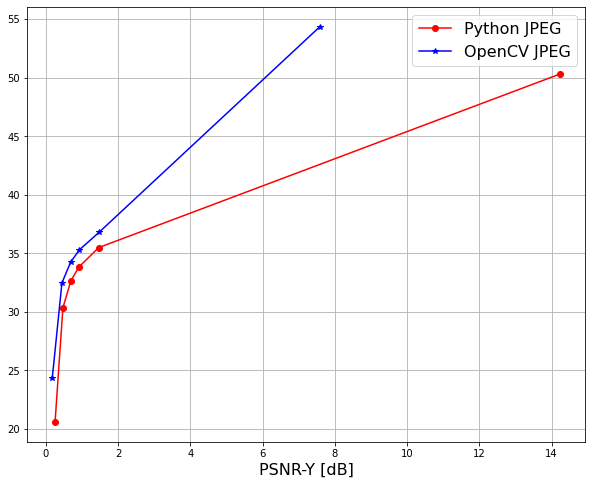

In [7]:
plt.figure(figsize=(10,8))

plt.plot(coding_rate, psnr[:, 0], 'r-o', label='Python JPEG')
plt.plot(coding_rate_cv2, psnr_cv2[:, 0], 'b-*', label='OpenCV JPEG')
plt.xlabel('Coding rate [bpp]', fontsize=16)
plt.xlabel('PSNR-Y [dB]', fontsize=16)
plt.legend(fontsize=16)
plt.grid();

From the rate-distortion curves obtained above we note that our encoder is far apart from the OpenCV one, especially at very low coding rates (e.g. 0.2bpp) as well as high coding rates. For coding rates in the range \[0.5 - 1.5\] bpp, the PSNR values obtained as less apart from the practical benchmark considered.

The superior coding efficiency achieved by the OpenCV's encoder may be associated with the following factors:
 * Use of different Huffman tables, computed on the actual data
 * Use of different quantisation tables, adapted on the image data using some of the state-of-the-art methods provided (for example) by the works of [A. B. Watson et al.](https://human-factors.arc.nasa.gov/organization/personnel_view.php?personnel_id=62)
 * Use of Rate Distortion Optimised Quantisation (RDOQ) techniques which adjust the quantisation process on a per block basis to improve the overall rate-distortion performance.

Worth also noting the big jump between quality factor 80 and 100 for both the encoders where the coding rate has more than a seven fold increase in the case of our Python implementation.

## Conclusions
We hope the reader has found this tutorial useful to learn the encoding processing associated with the JPEG compression standard when run in its baseline sequential DCT configuration. We elaborated on the design choices associated to each coding tool to provide the reader with useful links between what a textbook will tell about (e.g.) run length coding and then how it can be conveniently implemented with the packing of run lengths and value pairs.

The final comparison of the encoder implemented with a practical one also shed some light on the different aspects that should be addressed to close the rate-distortion performance gap observed.